In [1]:
!pip install typing_extensions==4.8.0
!pip install torch==2.4.1 torchvision
!pip install lightning pytorch-lightning timm
!pip install opencv-python-headless
!pip install grad_cam
!pip install pytorch_metric_learning
!pip install faiss-cpu

  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio 1.76.0 requires typing-extensions~=4.12, but you have typing-extensions 4.8.0 which is incompatible.
openai 1.109.1 requires typing-extensions<5,>=4.11, but you have typing-extensions 4.8.0 which is incompatible.
typeguard 4.4.4 requires typing_extensions>=4.14.0, but you have typing-extensions 4.8.0 which is incompatible.
pydantic 2.11.10 requires typing-extensions>=4.12.2, but you have typing-extensions 4.8.0 which is incompatible.
altair 5.5.0 requires typing-extensions>=4.10.0; python_version < "3.14", but you have typing-extensions 4.8.0 which is incompatible.
alembic 1.17.0 requires typing-extensions>=4.12

In [2]:
import os
if not os.path.exists("data.zip"):
    !gdown "https://drive.google.com/uc?id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx" -O data.zip
    !unzip data.zip

    !mv cars_train/cars_train/* cars_train/
    !rmdir cars_train/cars_train

    !mv cars_test/cars_test/* cars_test/
    !rmdir cars_test/cars_test


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cars_train/cars_train/03145.jpg  
  inflating: cars_train/cars_train/03146.jpg  
  inflating: cars_train/cars_train/03147.jpg  
  inflating: cars_train/cars_train/03148.jpg  
  inflating: cars_train/cars_train/03149.jpg  
  inflating: cars_train/cars_train/03150.jpg  
  inflating: cars_train/cars_train/03151.jpg  
  inflating: cars_train/cars_train/03152.jpg  
  inflating: cars_train/cars_train/03153.jpg  
  inflating: cars_train/cars_train/03154.jpg  
  inflating: cars_train/cars_train/03155.jpg  
  inflating: cars_train/cars_train/03156.jpg  
  inflating: cars_train/cars_train/03157.jpg  
  inflating: cars_train/cars_train/03158.jpg  
  inflating: cars_train/cars_train/03159.jpg  
  inflating: cars_train/cars_train/03160.jpg  
  inflating: cars_train/cars_train/03161.jpg  
  inflating: cars_train/cars_train/03162.jpg  
  inflating: cars_train/cars_train/03163.jpg  
  inflating: cars_train/cars_train/0316

In [3]:
if not os.path.exists("meta.zip"):
  !gdown "https://drive.google.com/uc?id=1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7" -O meta.zip
  !unzip meta.zip

Downloading...
From: https://drive.google.com/uc?id=1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7
To: /content/meta.zip
100% 332k/332k [00:00<00:00, 116MB/s]
Archive:  meta.zip
   creating: devkit/
  inflating: __MACOSX/._devkit       
  inflating: devkit/cars_test_annos.mat  
  inflating: __MACOSX/devkit/._cars_test_annos.mat  
  inflating: devkit/eval_train.m     
  inflating: __MACOSX/devkit/._eval_train.m  
  inflating: devkit/cars_meta.mat    
  inflating: __MACOSX/devkit/._cars_meta.mat  
  inflating: devkit/README.txt       
  inflating: __MACOSX/devkit/._README.txt  
  inflating: devkit/cars_train_annos.mat  
  inflating: __MACOSX/devkit/._cars_train_annos.mat  
  inflating: devkit/train_perfect_preds.txt  
  inflating: __MACOSX/devkit/._train_perfect_preds.txt  


In [4]:
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd

In [5]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

Device is: gpu


## 0. Знакомство с данными

In [6]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
# индексы классов картинок
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
# id в класс
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

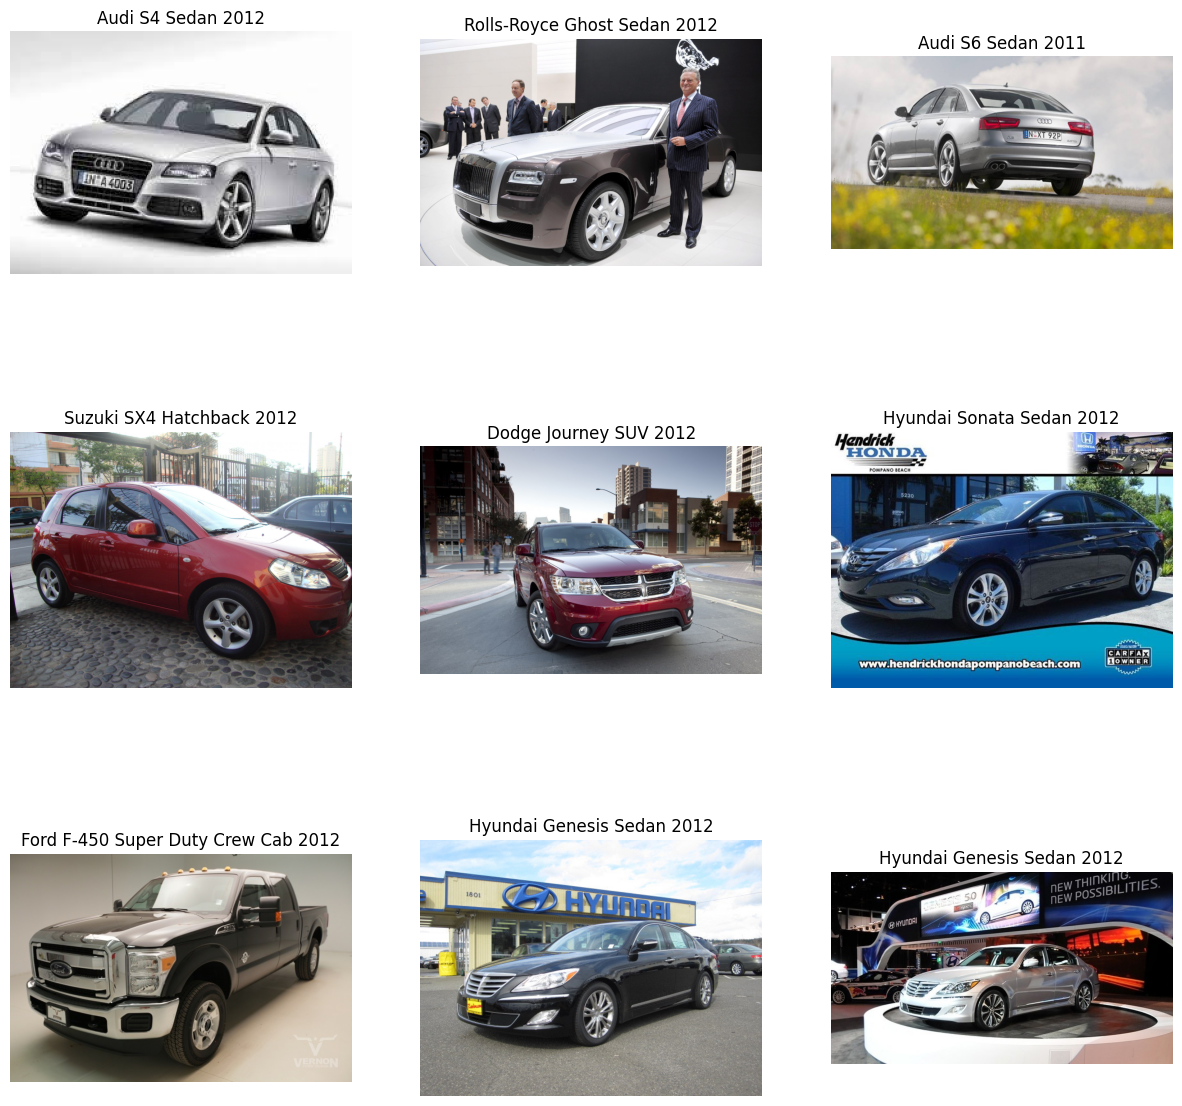

In [7]:
ADD_PATH = './cars_train'
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

↑ машины с разных ракурсов, мест, иногда с вотермарками

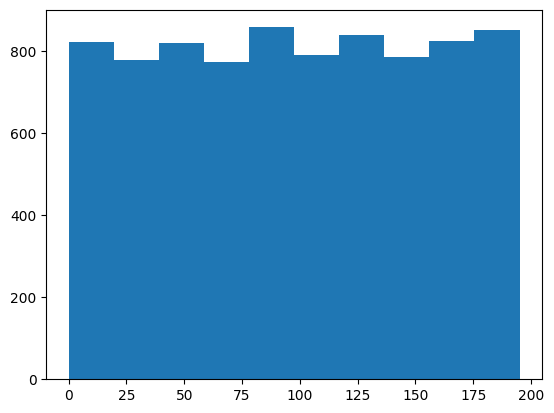

In [8]:
plt.hist(fname_to_class.values())
plt.show()

↑ классы сбалансированы

## 1. Добавление аугментаций и создание даталоудеров

In [9]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import torchvision.transforms as T

train_transforms = T.Compose([
    T.ToPILImage(),

    # аугментации:
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    T.ToTensor(),
    # подходит и для ResNet, и для EfficientNet
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),  # просто меняем размер
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [10]:
class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        idx = int(idx)  # важно для совместимости с sampler
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {
            'image': image,
            'label': int(cl_id)  # <-- вот здесь важно привести к Python int
        }
        return sample


In [11]:
items = list(fname_to_class.items())
random.seed(42)
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

In [12]:
from torch.utils.data import DataLoader
from pytorch_metric_learning.samplers import MPerClassSampler

def collate_fn(batch):
    images = torch.stack([x['image'] for x in batch])
    labels = torch.tensor([int(x['label']) for x in batch], dtype=torch.long)
    return {'image': images, 'label': labels}

# --- Список меток для MPerClassSampler ---
train_labels = [int(label) for _, label in train_items]

# --- Тренировочный DataLoader с sampler ---
train_loader = DataLoader(
    train_dataset,
    batch_size=32,  # можно увеличить, если хватает VRAM
    sampler=MPerClassSampler(
        labels=train_labels,
        m=4,  # на класс 4 примера
        length_before_new_iter=len(train_dataset)
    ),
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 2. Обучение модели с backboun EfficientNet

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from pytorch_metric_learning import miners, losses
from torchvision.models import efficientnet_b0


class CarEmbedderTriplet(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, emb_size=512):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.emb_size = emb_size

        # --- Backbone ---
        backbone = efficientnet_b0(pretrained=True)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.model = backbone

        # --- Embedding head ---
        self.embedding_head = nn.Linear(in_features, emb_size)

        # --- Triplet Loss + Miner ---
        self.triplet_loss = losses.TripletMarginLoss(margin=0.2)
        self.miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")

    def forward(self, x):
        features = self.model(x)
        embeddings = self.embedding_head(features)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"].long()
        embeddings = self(images)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.triplet_loss(embeddings, labels, hard_pairs)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=False)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"].long()
        embeddings = self(images)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.triplet_loss(embeddings, labels, hard_pairs)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False, logger=False)
        return loss

    def on_train_epoch_end(self):
        # печатаем train_loss после каждой эпохи
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            print(f"Epoch {self.current_epoch + 1} | train_loss: {train_loss:.4f}")

    def on_validation_epoch_end(self):
        # печатаем val_loss после каждой эпохи
        val_loss = self.trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            print(f"Epoch {self.current_epoch + 1} | val_loss: {val_loss:.4f}")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [18]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor

# model
pl_model = CarEmbedderTriplet()
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(
    max_epochs=40,
    accelerator=device,
    devices=1,
    precision=16,  # mixed precision
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    log_every_n_steps=10
    # enable_progress_bar=False
)

/usr/local/lib/python3.12/dist-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 4.0 M  | train
1 | embedding_head | Linear             | 655 K  | train
2 | triplet_loss   | TripletMarginLoss  | 0      | train
3 | miner          | TripletMarginMiner | 0      | train
--------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
341       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 | val_loss: 0.0813


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 | val_loss: 0.0835
Epoch 1 | train_loss: 0.1008


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 | val_loss: 0.0773
Epoch 2 | train_loss: 0.0941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 | val_loss: 0.0774
Epoch 3 | train_loss: 0.0913


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 | val_loss: 0.0742
Epoch 4 | train_loss: 0.0900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 | val_loss: 0.0800
Epoch 5 | train_loss: 0.0893


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 | val_loss: 0.0786
Epoch 6 | train_loss: 0.0881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 | val_loss: 0.0782
Epoch 7 | train_loss: 0.0871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 | val_loss: 0.0723
Epoch 8 | train_loss: 0.0862


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 | val_loss: 0.0651
Epoch 9 | train_loss: 0.0866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 | val_loss: 0.0724
Epoch 10 | train_loss: 0.0843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 | val_loss: 0.0683
Epoch 11 | train_loss: 0.0834


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 | val_loss: 0.0686
Epoch 12 | train_loss: 0.0845


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 | val_loss: 0.0701
Epoch 13 | train_loss: 0.0843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 | val_loss: 0.0689
Epoch 14 | train_loss: 0.0841


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 | val_loss: 0.0624
Epoch 15 | train_loss: 0.0829


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 | val_loss: 0.0613
Epoch 16 | train_loss: 0.0811


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 | val_loss: 0.0633
Epoch 17 | train_loss: 0.0804


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 | val_loss: 0.0651
Epoch 18 | train_loss: 0.0810


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 | val_loss: 0.0658
Epoch 19 | train_loss: 0.0798


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 | val_loss: 0.0663
Epoch 20 | train_loss: 0.0805


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 | val_loss: 0.0638
Epoch 21 | train_loss: 0.0797


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 | val_loss: 0.0627
Epoch 22 | train_loss: 0.0777


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 | val_loss: 0.0629
Epoch 23 | train_loss: 0.0774


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 | val_loss: 0.0638
Epoch 24 | train_loss: 0.0773


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 | val_loss: 0.0586
Epoch 25 | train_loss: 0.0775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 | val_loss: 0.0659
Epoch 26 | train_loss: 0.0746


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 | val_loss: 0.0597
Epoch 27 | train_loss: 0.0765


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 | val_loss: 0.0591
Epoch 28 | train_loss: 0.0743


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 | val_loss: 0.0646
Epoch 29 | train_loss: 0.0731


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 | val_loss: 0.0690
Epoch 30 | train_loss: 0.0739


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 | val_loss: 0.0696
Epoch 31 | train_loss: 0.0758


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 | val_loss: 0.0704
Epoch 32 | train_loss: 0.0749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 | val_loss: 0.0645
Epoch 33 | train_loss: 0.0737


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 | val_loss: 0.0653
Epoch 34 | train_loss: 0.0706


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 | val_loss: 0.0593
Epoch 35 | train_loss: 0.0714


In [21]:
metrics = trainer.callback_metrics
print("Train loss (epoch):", metrics['train_loss_epoch'].item())
print("Val loss:", metrics['val_loss'].item())
print("LR:", metrics['lr-Adam'].item())


Train loss (epoch): 0.07139360904693604
Val loss: 0.059295568615198135
LR: 9.999999747378752e-05


In [22]:
trainer.validate(model=pl_model, dataloaders=val_loader)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 | val_loss: 0.0593


[{}]

## 3. Поиск похожих изображений с помощью FAISS

In [23]:
import tqdm
import numpy as np
pl_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)
pl_model.to(device)
np.float32

Device is: cuda


numpy.float32

In [24]:

def get_embeds(model, loader):
    embeddings = np.empty((0, 512), dtype=np.float32)
    labels = np.empty((0,), dtype=np.int64)
    for batch in tqdm.tqdm(loader, desc="Getting embeddings"):
        imgs = batch['image'].to(device)
        label = batch['label'].numpy()
        with torch.no_grad():
            preds = model(imgs)
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label])
    return embeddings, labels

train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, val_loader)


Getting embeddings: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


In [29]:
import faiss
index = faiss.IndexFlatL2(512)
print(index.is_trained)
index.add(train_emb)
print(index.ntotal)

k = 4                          # 4 соседа
D, I = index.search(train_emb[:5], k)
print(I)
print(D)
D, I = index.search(val_emb, k)
print(I[:5])
print(I[-5:])

True
6272
[[   0 5367 5365    2]
 [   1 5366 5976 1813]
 [   2 4072 1412    0]
 [   3 4073 1415 1813]
 [   4 1497 2433 6132]]
[[0.         0.06452131 0.09049136 0.09050749]
 [0.         0.0365267  0.08490577 0.11301622]
 [0.         0.02120524 0.03388147 0.09050749]
 [0.         0.00730275 0.05034914 0.05460737]
 [0.         0.06016018 0.07026075 0.08076331]]
[[1596  846  661 5310]
 [2131 2839 2838 3263]
 [2666 5321 4934 4932]
 [3453 6091  821  384]
 [6195 1313 1315 2864]]
[[3287 3440  586 3102]
 [2778  733 3994 2826]
 [1655 6032 3000 1039]
 [2731  109 5544  110]
 [2465 1575   32 5172]]


In [30]:
Distances, Indexes = index.search(val_emb, 1)
print(f'Precision@1: {np.mean(val_labels == train_labels[Indexes.flatten()]):.4f}')


Precision@1: 0.6556


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch

fname_to_desc = {fname: id_to_car[cls] for fname, cls in fname_to_class.items()}

# --- Функция для визуализации ---
def show_val_image_with_neighbors(val_idx=0, k=4):
    val_fname, val_label = val_items[val_idx]
    query_emb = val_emb[val_idx:val_idx+1]  # берём из val_emb

    D, I = index.search(query_emb, k)
    neighbors = I[0]
    distances = D[0]

    query_img = Image.open(os.path.join(ADD_PATH, val_fname)).convert("RGB")
    query_desc = fname_to_desc.get(val_fname, "")

    fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 3))
    axes[0].imshow(np.array(query_img))
    axes[0].set_title(f"Query\nLabel: {val_label}\n{query_desc}")
    axes[0].axis("off")

    for j, n_idx in enumerate(neighbors):
        n_fname, n_label = train_items[n_idx]
        neighbor_img = Image.open(os.path.join(ADD_PATH, n_fname)).convert("RGB")
        neighbor_desc = fname_to_desc.get(n_fname, "")
        axes[j+1].imshow(np.array(neighbor_img))
        axes[j+1].set_title(f"Label: {n_label}\n{neighbor_desc}\nDist: {distances[j]:.3f}")
        axes[j+1].axis("off")

    plt.show()




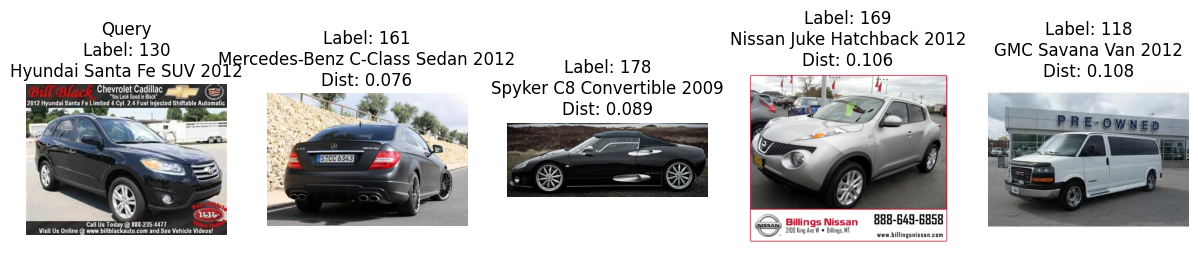

In [37]:
# --- Использование ---
show_val_image_with_neighbors(val_idx=1, k=4)

## 4. Подсчет метрик

In [35]:
import numpy as np
import faiss
from tqdm import tqdm
import tqdm

train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, val_loader)

index = faiss.IndexFlatL2(train_emb.shape[1])
index.add(train_emb)

K = 10
D, I = index.search(val_emb, K)  # D — дистанции, I — индексы соседей

def precision_recall_at_k(val_labels, train_labels, I, k_values=[1, 5, 10]):
    results = {}
    for k in k_values:
        retrieved = train_labels[I[:, :k]]  # ближайшие K классов
        correct = (retrieved == val_labels[:, None])
        precision = np.mean(np.sum(correct, axis=1) / k)
        recall = np.mean(np.sum(correct, axis=1) / 1)  # 1, т.к. один true класс
        results[f"P@{k}"] = precision
        results[f"R@{k}"] = recall
    return results


def mean_average_precision(val_labels, train_labels, I, k=10):
    APs = []
    for i in range(len(val_labels)):
        relevant = (train_labels[I[i]] == val_labels[i])
        if not np.any(relevant):
            APs.append(0)
            continue
        precisions = []
        for j in range(1, k + 1):
            p_at_j = np.sum(relevant[:j]) / j
            precisions.append(p_at_j if relevant[j - 1] else 0)
        APs.append(np.mean(precisions))
    return np.mean(APs)


metrics = precision_recall_at_k(val_labels, train_labels, I, k_values=[1, 5, 10])
map_score = mean_average_precision(val_labels, train_labels, I, k=10)


Getting embeddings: 100%|██████████| 51/51 [00:12<00:00,  4.09it/s]


In [36]:
print("\nRetrieval metrics:")

for key in sorted(metrics.keys(), key=lambda x: (x[0], int(x.split('@')[1]))):
    print(f"{key}: {metrics[key]:.4f}")

# mAP
print(f"mAP@{10}: {map_score:.4f}")


Retrieval metrics:
P@1: 0.6452
P@5: 0.6253
P@10: 0.6041
R@1: 0.6452
R@5: 3.1265
R@10: 6.0405
mAP@10: 0.5380


## 5. GradCam

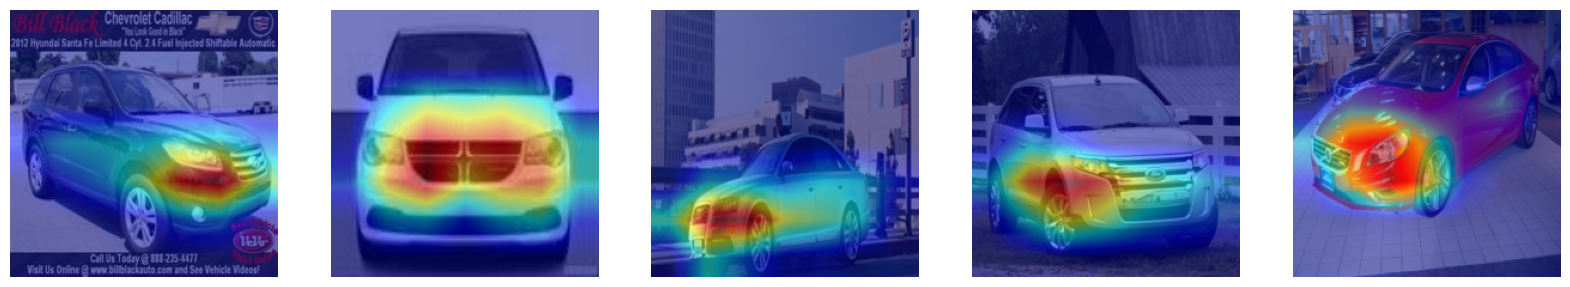

In [38]:
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- трансформация для отображения ---
transform_to_show = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

def get_image_from_dataset(idx, dataset, device):
    """
    Берем изображение из датасета по индексу и готовим его для GradCAM.
    Возвращаем:
        - orig_im: исходное изображение 512x512 для визуализации
        - rgb_im: нормализованное изображение float [0,1] для наложения CAM
        - input_tensor: тензор 1xCxy для передачи в модель
    """
    sample = dataset[idx]
    image = sample['image']
    image_label = sample['label']

    # convert tensor to numpy for visualization
    image_float = image.permute(1,2,0).cpu().numpy()
    image_float = (image_float - image_float.min()) / (image_float.max() - image_float.min())

    # resize для визуализации
    orig_im = cv2.resize(image_float, (512,512))
    input_tensor = image.unsqueeze(0).to(device)

    return orig_im, image_float, input_tensor, image_label

# --- выбираем слой для GradCAM ---
# Для EfficientNet-B0 обычно target_layers = [model.features[-1]]
target_layers = [pl_model.model.features[-1]]  # последние conv-слои

# --- функция для генерации CAM ---
def generate_gradcam(input_tensor, image_float, model, target_layers):
    with GradCAM(model=model.model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    cam_image = show_cam_on_image(image_float, grayscale_cam, use_rgb=True)
    return cam_image

# --- создаем примеры из val_dataset ---
num_examples = 5
cam_images = []
for i in range(num_examples):
    orig_im, image_float, input_tensor, label = get_image_from_dataset(i, val_dataset, device)
    cam_image = generate_gradcam(input_tensor, image_float, pl_model, target_layers)
    cam_images.append(cam_image)

# --- объединяем в сетку для просмотра ---
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_examples, figsize=(4*num_examples,4))
for i, cam_img in enumerate(cam_images):
    axs[i].imshow(cam_img)
    axs[i].axis('off')
plt.show()


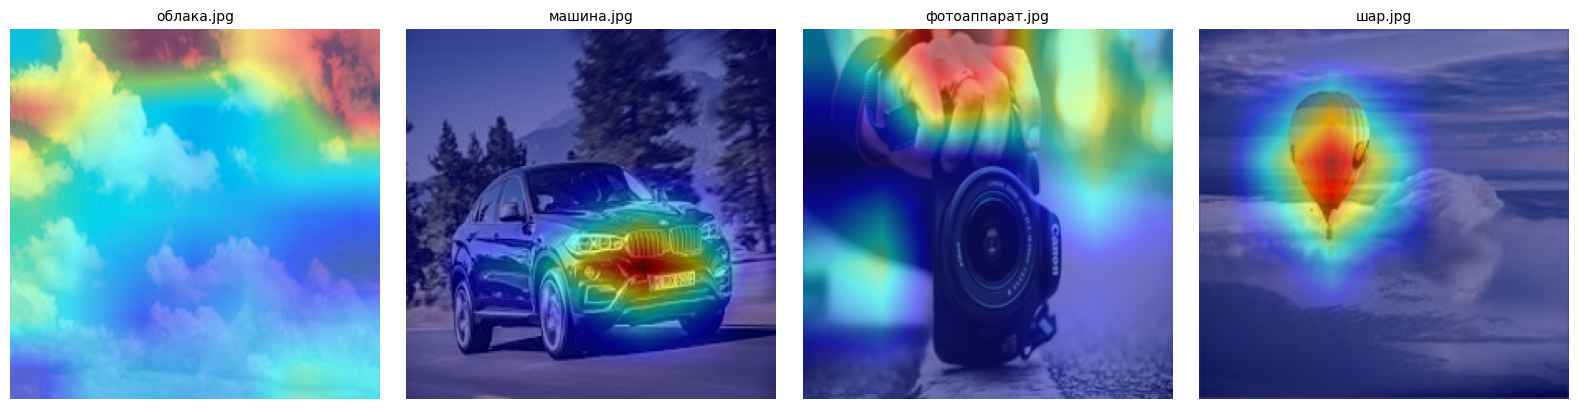

In [42]:
import os
import random
import numpy as np
import cv2
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# --- путь к папке ---
images_dir = "images"

# --- получаем список файлов jpg ---
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.lower().endswith(".jpg")]
random.shuffle(image_files)

# --- выбираем слой для GradCAM (тот же, что и для валидации) ---
target_layers = [pl_model.model.features[-1]]

# --- функция для подготовки изображения из папки ---
def get_image_from_path(path, device):
    """Загружает изображение из пути, применяет трансформации, готовит тензор и данные для визуализации."""
    # читаем и конвертируем RGB
    orig = Image.open(path).convert("RGB")

    # для визуализации — float [0,1]
    img_for_vis = np.array(orig.resize((224, 224))) / 255.0

    # для модели — как в val_transforms
    transformed = val_transforms(np.array(orig)).unsqueeze(0).to(device)

    return img_for_vis, transformed

# --- функция для генерации CAM ---
def generate_gradcam(input_tensor, image_float, model, target_layers):
    with GradCAM(model=model.model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    cam_image = show_cam_on_image(image_float, grayscale_cam, use_rgb=True)
    return cam_image

# --- создаем GradCAM для случайных картинок из папки ---
num_examples = min(5, len(image_files))
selected_files = image_files[:num_examples]
cam_images = []

for path in selected_files:
    image_float, input_tensor = get_image_from_path(path, device)
    cam_image = generate_gradcam(input_tensor, image_float, pl_model, target_layers)
    cam_images.append((os.path.basename(path), cam_image))

# --- визуализируем ---
fig, axs = plt.subplots(1, num_examples, figsize=(4*num_examples, 4))
for i, (name, cam_img) in enumerate(cam_images):
    axs[i].imshow(cam_img)
    axs[i].set_title(name, fontsize=10)
    axs[i].axis('off')
plt.tight_layout()
plt.show()
